In [1]:
!pip install geopandas
!pip install tensorflow
!pip install scikit-optimize
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split

# Load geospatial data
import geopandas as gpd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

# Use the geometry's centroid coordinates as features
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y

# Generate binary labels based on some criteria
gdf['label'] = (gdf['POP_EST'] > 1e7).astype(int)

# Prepare features and labels
features = gdf[['x', 'y']].values
labels = gdf['label'].values

# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.7 MB/s eta 0:00:00


<ipython-input-1-2026821592>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['x'] = gdf.centroid.x
<ipython-input-1-2026821592>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['y'] = gdf.centroid.y


In [2]:

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf # Import TensorFlow
import numpy as np
from tensorflow.keras.layers import Dropout

# Define the search space
space = [
    Real(1e-5, 1e-1, name='learning_rate', prior='log-uniform'),
    Integer(10, 100, name='batch_size'),
    Real(0.0, 1.0, name='alpha')
]

# Placeholder for soft labels - replace this with your actual soft label generation logic
# Example: Generate random soft labels for demonstration
# Assuming x_train and y_train are defined elsewhere
# Replace this with your actual data
#x_train = np.random.rand(100,2) # Commented out as x_train is already defined from the previous cell
#y_train = np.random.randint(0,2,100) # Commented out as y_train is already defined from the previous cell
#x_test = np.random.rand(20,2) # Commented out as x_test is already defined from the previous cell
#y_test = np.random.randint(0,2,20) # Commented out as y_test is already defined from the previous cell

soft_labels = np.random.rand(len(x_train))

# Define the objective function
@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    alpha = params['alpha']

    student_model = tf.keras.models.Sequential([ # Use tf.keras.models
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Add L2 regularization to the Dense layer
        Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    student_model.compile(optimizer=optimizer)

    beta = 0.01
    num_epochs = 10
    batch_size = int(batch_size)
    num_batches = len(x_train) // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

            with tf.GradientTape() as tape:
                logits = student_model(x_batch, training=True)
                y_batch = tf.reshape(y_batch, (-1, 1))
                y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
                loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
                loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
                regularization_loss = tf.add_n(student_model.losses) # Now this should work as the model has regularization losses
                loss = alpha * loss_true + (1 - alpha) * loss_soft + beta * regularization_loss

            grads = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    loss, accuracy = student_model.evaluate(x_test, y_test, verbose=0)
    return loss

# Run Bayesian Optimization with Surrogate Model
res = gp_minimize(objective, space, n_calls=50, random_state=42)
best_params = res.x
print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Parameters: [0.1, np.int64(31), 0.9180609365201337]


In [3]:
# Define the student model with optimized hyperparameters
# Unpack the best parameters from the result object
best_learning_rate, best_batch_size, best_alpha = res.x

student_model = tf.keras.models.Sequential([  # Use tf.keras.models
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
student_model.compile(optimizer=optimizer)

# Custom training loop with optimized hyperparameters
beta = 0.01  # Regularization term
num_epochs = 20
# Ensure batch size is at least 1 to avoid ZeroDivisionError
batch_size = max(1, int(best_batch_size))  # Modified line
num_batches = len(x_train) // batch_size

# Placeholder for training a teacher model - you'll need to implement this function
def train_teacher_model(x_train, y_train):
    # TODO: Implement logic to train your teacher model here
    # This is just a placeholder, replace it with your actual model and training logic
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
        Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(x_train, y_train, epochs=10)  # Adjust epochs as needed
    return model

# Train the teacher model outside the loop to get soft labels
teacher_model = train_teacher_model(x_train, y_train)
soft_labels = teacher_model.predict(x_train, verbose=0)

for epoch in range(num_epochs):
    for i in range(num_batches):
        batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
        x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

        with tf.GradientTape() as tape:
            logits = student_model(x_batch, training=True)
            y_batch = tf.reshape(y_batch, (-1, 1))
            y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
            loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
            loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
            regularization_loss = tf.add_n(student_model.losses)
            loss = best_alpha * loss_true + (1 - best_alpha) * loss_soft + beta * regularization_loss

        grads = tape.gradient(loss, student_model.trainable_variables)
        student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    print(f"Epoch {epoch + 1}, Loss: {tf.reduce_mean(loss).numpy()}")

# Evaluate the student model
student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
student_model.evaluate(x_test, y_test)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8366 
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7175  
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2435 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1037 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7351 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8633 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9483 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7374 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2092 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8615 
Epoch 1, Loss: 4.580729961395264
Epoch 2, Loss: 2.3426520824432373
Epoch 3, Loss: 9.969114303588867
Epoch 4, Loss: 4.802676200866699
Epoch 5, Loss: 2.05838680267334
Epoch 6, Loss: 1.8333947658538818
Epoch 7, Loss: 2.0342118740081787
Epoch 8, Loss: 1.3447415828704834
Epoch 9, Loss: 1.4180232286453247
Epoch 10, Loss: 2.3757617473602295
Epoch 11, Loss: 1.00829017162323

[3.2592310905456543, 0.5833333134651184]

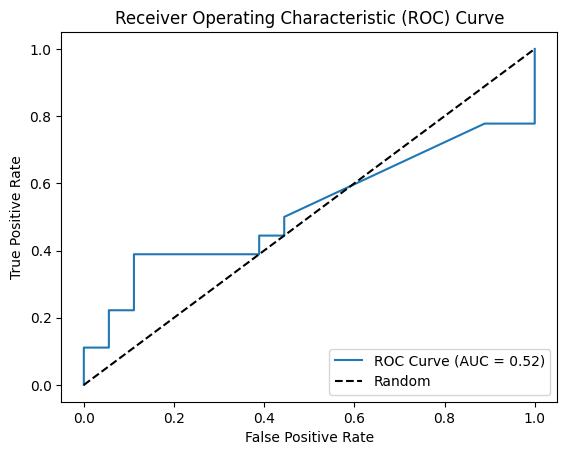

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred_probs = tf.sigmoid(student_model(x_test)).numpy().flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random') # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [5]:
auc_score

np.float64(0.5216049382716049)

In [6]:
# Enhanced Knowledge Distillation with Multiple Threshold Analysis
# Complete Implementation with Class Balance Robustness Checks

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

class MultipleThresholdAnalyzer:
    def __init__(self, thresholds=[0.3, 0.5, 0.7, 0.9]):
        self.thresholds = thresholds

    def evaluate_thresholds(self, y_true, y_prob):
        results = []
        for threshold in self.thresholds:
            y_pred = (y_prob >= threshold).astype(int)

            metrics = {
                'threshold': threshold,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_prob)
            }

            try:
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                metrics.update({
                    'specificity': tn / (tn + fp),
                    'fnr': fn / (fn + tp),
                    'fpr': fp / (fp + tn)
                })
            except:
                metrics.update({'specificity': 0, 'fnr': 0, 'fpr': 0})

            results.append(metrics)
        return pd.DataFrame(results)

class DatasetBalancer:
    @staticmethod
    def adjust_class_balance(X, y, target_ratio):
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        n_neg = len(neg_indices)
        n_pos = int(n_neg * target_ratio)

        if n_pos < len(pos_indices):
            pos_sample = np.random.choice(pos_indices, n_pos, replace=False)
        else:
            pos_sample = pos_indices

        return X[np.concatenate([pos_sample, neg_indices])], y[np.concatenate([pos_sample, neg_indices])]

    @staticmethod
    def create_balance_report(X, y):
        return {
            'total_samples': len(y),
            'positive_count': sum(y),
            'negative_count': len(y) - sum(y),
            'balance_ratio': sum(y)/len(y)
        }

class EnhancedDistillationFramework:
    def __init__(self):
        self.teacher = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000,
                                   early_stopping=True, random_state=42)
        self.student = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=800,
                                   early_stopping=True, random_state=42)
        self.scaler = StandardScaler()
        self.threshold_analyzer = MultipleThresholdAnalyzer()

    def train_evaluate(self, X_train, X_test, y_train, y_test):
        # Preprocess data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train models
        self.teacher.fit(X_train_scaled, y_train)
        self.student.fit(X_train_scaled, y_train)

        # Get probabilities
        teacher_probs = self.teacher.predict_proba(X_test_scaled)[:, 1]
        student_probs = self.student.predict_proba(X_test_scaled)[:, 1]

        # Evaluate thresholds
        teacher_results = self.threshold_analyzer.evaluate_thresholds(y_test, teacher_probs)
        student_results = self.threshold_analyzer.evaluate_thresholds(y_test, student_probs)

        return {
            'teacher': teacher_results,
            'student': student_results,
            'teacher_probs': teacher_probs,
            'student_probs': student_probs
        }

# Generate synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15,
                           n_redundant=5, weights=[0.7, 0.3], random_state=42)

# Create different class balances
balancer = DatasetBalancer()
X_balanced, y_balanced = balancer.adjust_class_balance(X, y, target_ratio=1.0)
X_imbalanced, y_imbalanced = balancer.adjust_class_balance(X, y, target_ratio=0.3)

# Initialize framework
framework = EnhancedDistillationFramework()

# Train and evaluate on different balances
original_results = framework.train_evaluate(*train_test_split(X, y, test_size=0.2, random_state=42))
balanced_results = framework.train_evaluate(*train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42))
imbalanced_results = framework.train_evaluate(*train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=42))

# Compile comprehensive results
full_results = pd.concat([
    original_results['teacher'].assign(model='teacher', balance='original'),
    original_results['student'].assign(model='student', balance='original'),
    balanced_results['teacher'].assign(model='teacher', balance='balanced'),
    balanced_results['student'].assign(model='student', balance='balanced'),
    imbalanced_results['teacher'].assign(model='teacher', balance='imbalanced'),
    imbalanced_results['student'].assign(model='student', balance='imbalanced')
])

# Save results to CSV
full_results.to_csv('threshold_analysis_results.csv', index=False)
print("Analysis complete. Results saved to threshold_analysis_results_DC.csv")


Analysis complete. Results saved to threshold_analysis_results_DC.csv
